In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import os
import zipfile
import shutil
from glob import glob 


from tensorflow.keras.datasets import mnist
import tensorflow.keras.utils as utils

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Project 1

- ImageDataGenrator와 TL을 이용해서 오버 피팅이 최소가 되게 정확도 90% 이상 달성.

- 만약 오버 피팅이 심하고 90% 이상의 성능이 나오지 않는다면, 문제점과 개선안을 찾아본다.

# 엑스레이 

- https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
- 과적합적고 정확도 90이상.

- val은 train 10% 이상되게

## 경로 설정

In [13]:
ROOT_DIR = 'content'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'Chest_Xray_Pneumonia')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "train")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "test")
VALIDATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "val")


In [ ]:
# #### Colab
# ROOT_DIR = '/content'
# DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'Chest_Xray_Pneumonia')
# TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Training')
# TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'Testing')
# VALIDATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'val')

## 데이터셋 가져오기

In [ ]:
# #### Colab

# from google.colab import drive

# drive.mount('/content/')

# shutil.copy(os.path.join('/content/My Drive/Colab Notebooks/', 'archive (3).zip'))

# if os.path.exists(DATA_ROOT_DIR):
#     shutil.rmtree(DATA_ROOT_DIR)
    
# with zipfile.ZipFile(os.path.join(ROOT_DIR, 'archive (3).zip'), 'r') as target_file:
#     target_file.extractall(DATA_ROOT_DIRA_ROOT_DIR)

In [8]:
#### PC
if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'archive (3).zip'), 'r') as target_file:
    target_file.extractall(DATA_ROOT_DIR)

In [11]:
os.listdir('C:\dohyun0207\PythonWork\AI\content\Chest_Xray_Pneumonia\chest_xray')

['chest_xray', 'test', 'train', 'val', '__MACOSX']

## 정답및 전체 데이터 갯수 확인

In [14]:
print(os.listdir(TRAIN_DATA_ROOT_DIR))
print(TRAIN_DATA_ROOT_DIR)

for i in range(len(os.listdir(TRAIN_DATA_ROOT_DIR))):
    
    path = os.path.join(TRAIN_DATA_ROOT_DIR, os.listdir(TRAIN_DATA_ROOT_DIR)[i])
    print('Train ', os.listdir(TRAIN_DATA_ROOT_DIR)[i], len(os.listdir(path)))
    
print('=========' * 6)

for i in range(len(os.listdir(TEST_DATA_ROOT_DIR))):
    
    path = os.path.join(TEST_DATA_ROOT_DIR, os.listdir(TEST_DATA_ROOT_DIR)[i])
    print('Test ', os.listdir(TEST_DATA_ROOT_DIR)[i], len(os.listdir(path)))
    
print('=========' * 6)
    
for i in range(len(os.listdir(TEST_DATA_ROOT_DIR))):
    
    path = os.path.join(VALIDATION_DATA_ROOT_DIR, os.listdir(VALIDATION_DATA_ROOT_DIR)[i])
    print('Val ', os.listdir(VALIDATION_DATA_ROOT_DIR)[i], len(os.listdir(path)))

['NORMAL', 'PNEUMONIA']
content\Chest_Xray_Pneumonia\train
Train  NORMAL 1341
Train  PNEUMONIA 3875
Test  NORMAL 234
Test  PNEUMONIA 390
Val  NORMAL 8
Val  PNEUMONIA 8


## Image Shape 설정

In [16]:
IMG_WIDTH = 100
IMG_HEIGHT = 100

## ImageDataGenerator를 이용하여 데이터 불러오기

In [21]:
train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [29]:
train_generator = train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR,
                                                batch_size=32, color_mode='rgb',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                class_mode = 'sparse', shuffle = True,
                                                subset='training')

val_generator = train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR,
                                                batch_size=32, color_mode='rgb',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                class_mode = 'sparse', shuffle = True,
                                                subset='validation')

test_generator = test_data_gen.flow_from_directory(directory=TEST_DATA_ROOT_DIR,
                                                batch_size=32, color_mode='rgb',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                class_mode = 'sparse', shuffle = True)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [30]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'NORMAL': 0, 'PNEUMONIA': 1}
2


### 16 장의 이미지 확인

- ImageDataGenerator를 통해 전달된 이미지 출력

In [31]:
img, label = train_generator.next()
img = img[:16]
label = label[:16]

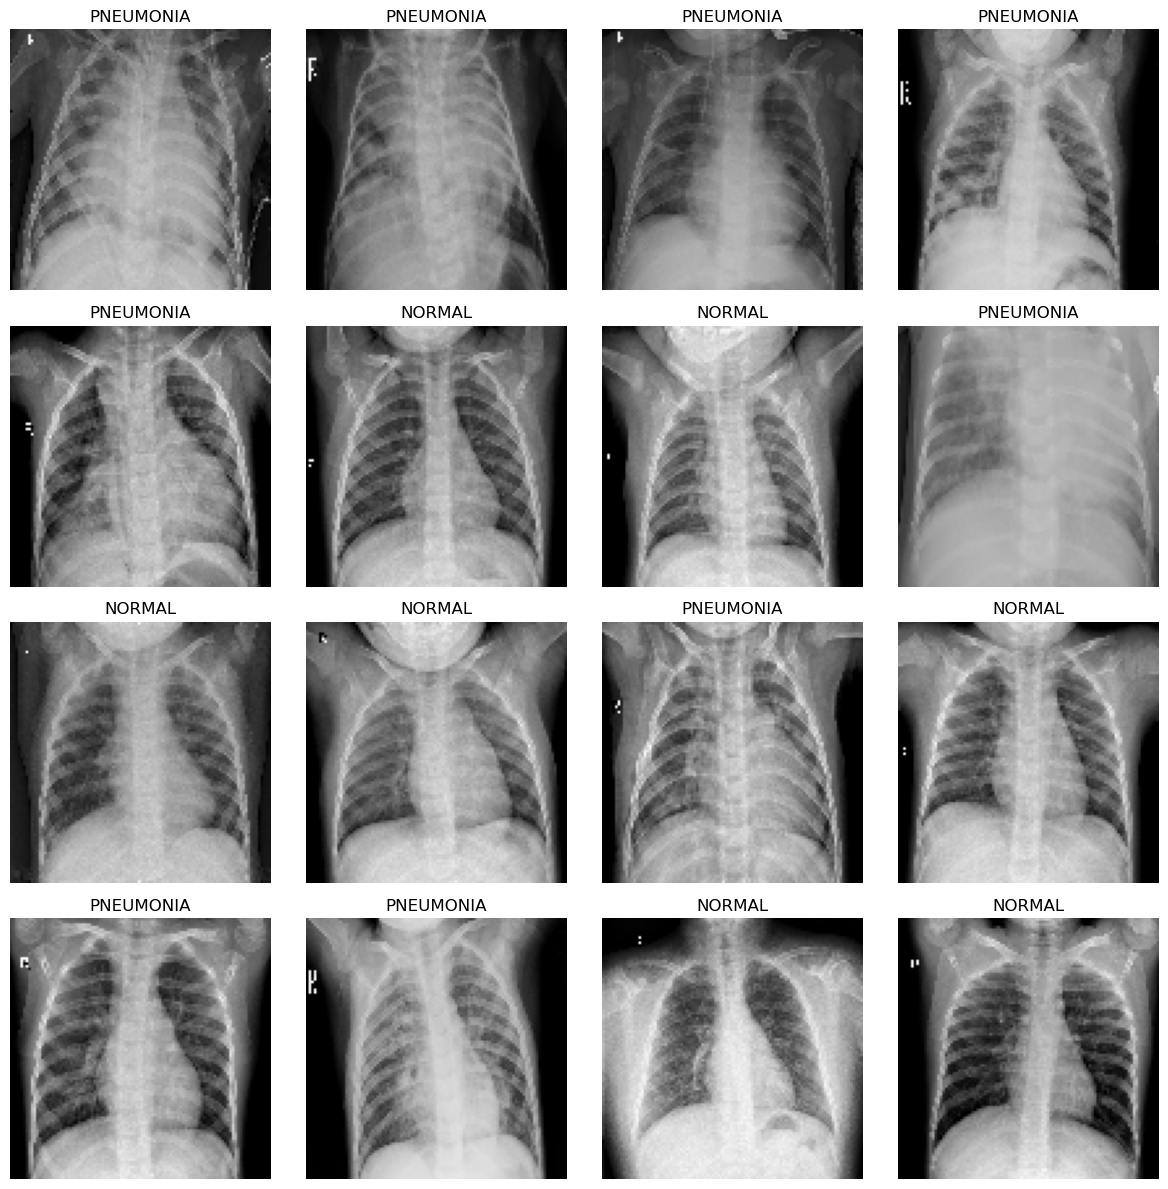

In [32]:
class_name = {0:'NORMAL', 1:'PNEUMONIA'}   
    
plt.figure(figsize=(12, 12))
for i in range(len(img)):
    plt.subplot(4, 4, i+1)
    plt.title(class_name[int(label[i])])
    plt.imshow(img[i])
    plt.axis('off')
plt.tight_layout()
    

## Fine Tuining을 위한 pre-trained 정의 및 모델 구축

In [33]:
pre_trained_model = MobileNet(weights='imagenet', include_top=False,
                             input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8 (Conv2D)          (None, 6, 6, 512)         262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 6, 6, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_pw_9

In [34]:
model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                16400     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 3,245,298
Trainable params: 3,223,410
Non-

In [35]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=Adam(1e-5), metrics=['acc'])

In [36]:
start_time = datetime.now()

result = model.fit(train_generator, epochs=3, validation_data=val_generator) # epochs = 10? 30?

end_time = datetime.now()

print('Run time :', end_time - start_time)

Epoch 1/3
131/131 [==============================] - 129s 938ms/step - loss: 0.5878 - acc: 0.7568 - val_loss: 0.5058 - val_acc: 0.8006
Epoch 2/3
131/131 [==============================] - 67s 510ms/step - loss: 0.3645 - acc: 0.8385 - val_loss: 0.2919 - val_acc: 0.8715
Epoch 3/3
131/131 [==============================] - 68s 519ms/step - loss: 0.2779 - acc: 0.8802 - val_loss: 0.2044 - val_acc: 0.9156
Run time : 0:04:25.938268


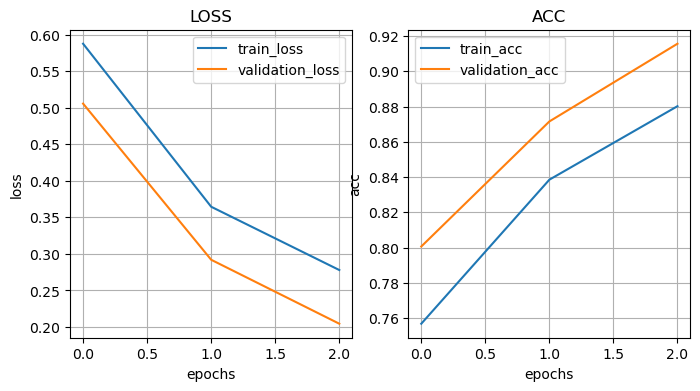

In [37]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")
# plt.show()

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.grid()

plt.plot(result.history["acc"], label="train_acc")
plt.plot(result.history["val_acc"], label="validation_acc")
plt.legend(loc="best")
plt.show()


In [38]:
model.evaluate(test_generator)

20/20 [==============================] - 9s 473ms/step - loss: 0.7030 - acc: 0.7083


[0.703014612197876, 0.7083333134651184]

In [40]:
test_simple_dataget = ImageDataGenerator(rescale = 1./255)

test_simple_generator = train_data_gen.flow_from_directory(directory=VALIDATION_DATA_ROOT_DIR,
                                                batch_size=32, color_mode='rgb',
                                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                class_mode = 'sparse', shuffle = True,
                                                subset='validation')

Found 2 images belonging to 2 classes.


In [41]:
model.evaluate(test_simple_generator)

1/1 [==============================] - 0s 57ms/step - loss: 3.3868 - acc: 0.5000


[3.386807918548584, 0.5]